In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import iris
import iris.analysis
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.coord import add_cyclic_point_to_cube

In [3]:
from commons import EXPERIMENTS, LAYERS, SEASONS
from mypaths import path_to_results, path_to_ukca
from plot_func import use_paper_style  # use_draft_style
from proc_func import GASES

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()
# use_draft_style()

In [5]:
# Choose experiments
base_exp_name = "BASE"
sens_exp_name = "FULL"
# Choose layer
layer = "BL"  # BL or FT

In [6]:
base_cl = iris.cube.CubeList()
sens_cl = iris.cube.CubeList()
for ngas, gasdict in GASES.items():
    if gasdict["noy"]:
        # Load mass mixing ratios [kg kg-1] of NOy species and convert them to volume mixing ratios [ppb]
        base_cb = (
            iris.load_cube(
                str(path_to_ukca / EXPERIMENTS[base_exp_name] / f"{EXPERIMENTS[base_exp_name]}_{ngas}.nc"),
                f"{ngas}",
            )
            * GASES[ngas]["mmr_to_vmr"]
            * 1e9
        )
        sens_cb = (
            iris.load_cube(
                str(path_to_ukca / EXPERIMENTS[sens_exp_name] / f"{EXPERIMENTS[sens_exp_name]}_{ngas}.nc"),
                f"{ngas}",
            )
            * GASES[ngas]["mmr_to_vmr"]
            * 1e9
        )
        base_cb.rename(ngas)
        sens_cb.rename(ngas)

        # Remove the first year of data as a spin up
        base_cb_trimmed = base_cb[12::, ...]
        if sens_exp_name == "FIRE":
            # Remove faulty data from FIRE (xojnv) simulation
            sens_cb_trimmed = iris.cube.CubeList(
                [sens_cb[12:72, ...], sens_cb[84:120, ...]]
            ).concatenate()[0]
        else:
            sens_cb_trimmed = sens_cb[12::, ...]

        base_cl.append(base_cb_trimmed)
        sens_cl.append(sens_cb_trimmed)

In [7]:
# Calculate NOy sum
base_noy = sum(base_cl)
sens_noy = sum(sens_cl)
base_noy.rename("noy")
sens_noy.rename("noy")

# Add additional time coordinates
iris.coord_categorisation.add_season(base_noy, "time", name="season")
iris.coord_categorisation.add_season(sens_noy, "time", name="season")
iris.coord_categorisation.add_season_year(base_noy, "time", name="year")
iris.coord_categorisation.add_season_year(sens_noy, "time", name="year")

In [8]:
# Calculate RONO2 sum
base_rono2 = sum(base_cl.extract(["meono2", "etono2", "nprono2", "iprono2"]))
sens_rono2 = sum(sens_cl.extract(["meono2", "etono2", "nprono2", "iprono2"]))
base_rono2.rename("rono2")
sens_rono2.rename("rono2")

# Add additional time coordinates
iris.coord_categorisation.add_season(base_rono2, "time", name="season")
iris.coord_categorisation.add_season(sens_rono2, "time", name="season")
iris.coord_categorisation.add_season_year(base_rono2, "time", name="year")
iris.coord_categorisation.add_season_year(sens_rono2, "time", name="year")

# Note: RONO2 concentrations are zero in the BASE experiment

In [9]:
def calc_seasonal_mean_in_layer(cube, season, layer):
    """Calculate seasonal mean in a specified layer and add a cyclic longitude."""
    SEASON = iris.Constraint(season=season)
    cb = cube.extract(SEASON & layer).collapsed(["season", "level_height"], iris.analysis.MEAN)
    cyclic_cb = add_cyclic_point_to_cube(cb)
    return cyclic_cb

In [10]:
# Calculate NOy and RONO2 seasonal means in an layer
base_noy_by_ssn = iris.cube.CubeList()
sens_noy_by_ssn = iris.cube.CubeList()
base_rono2_by_ssn = iris.cube.CubeList()
sens_rono2_by_ssn = iris.cube.CubeList()
for ssn in SEASONS:
    base_noy_by_ssn.append(calc_seasonal_mean_in_layer(base_noy, ssn, LAYERS[layer]["iris_constr"]))
    sens_noy_by_ssn.append(calc_seasonal_mean_in_layer(sens_noy, ssn, LAYERS[layer]["iris_constr"]))
    base_rono2_by_ssn.append(
        calc_seasonal_mean_in_layer(base_rono2, ssn, LAYERS[layer]["iris_constr"])
    )
    sens_rono2_by_ssn.append(
        calc_seasonal_mean_in_layer(sens_rono2, ssn, LAYERS[layer]["iris_constr"])
    )

In [12]:
# Calculate RONO2 contribution to NOy [%]
base_rono2_pct_of_noy = iris.cube.CubeList()
for icb, jcb in zip(base_noy_by_ssn, base_rono2_by_ssn):
    base_rono2_pct_of_noy.append(jcb * 100 / icb)

sens_rono2_pct_of_noy = iris.cube.CubeList()
for icb, jcb in zip(sens_noy_by_ssn, sens_rono2_by_ssn):
    sens_rono2_pct_of_noy.append(jcb * 100 / icb)

In [11]:
# Horizontal grid
lats = base_cb.coord("latitude").points
lons = base_noy_by_ssn[0].coord("longitude").points

In [13]:
def plt_ssn_means(exp_name, cubelist, lons, lats):
    from commons import SEASONS

    if exp_name == "FIRE":
        map_kw = dict(transform=ccrs.PlateCarree(), cmap="Purples")
    else:
        map_kw = dict(transform=ccrs.PlateCarree(), cmap="Purples", levels=np.arange(0, 110, 10),)

    fig, axes = plt.subplots(
        nrows=4,
        ncols=1,
        figsize=(6, 12),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
    )
    for cube, ssn, ax in zip(cubelist, SEASONS, axes.flatten()):
        p0 = ax.contourf(lons, lats, cube.data, **map_kw)
        ax.coastlines(color="k")
        ax.set_title(ssn.upper(), loc="left", y=0.89)
    axes[0].set_title(exp_name, x=0.28, weight="bold")
    axes[0].set_title(LAYERS[layer]["tex"], loc="right", weight="bold")

    cax = fig.add_axes([0.245, 0.1, 0.53, 0.01])
    fig.colorbar(p0, cax=cax, orientation="horizontal", label="$RONO_2$ contribution to $NO_y$, %")
    fig.subplots_adjust(hspace=0.05)
    figname = f"{exp_name.lower()}_rono2_pct_of_noy"
    fig.savefig(path_to_results / "xojn" / "rono2_in_noy" / figname)

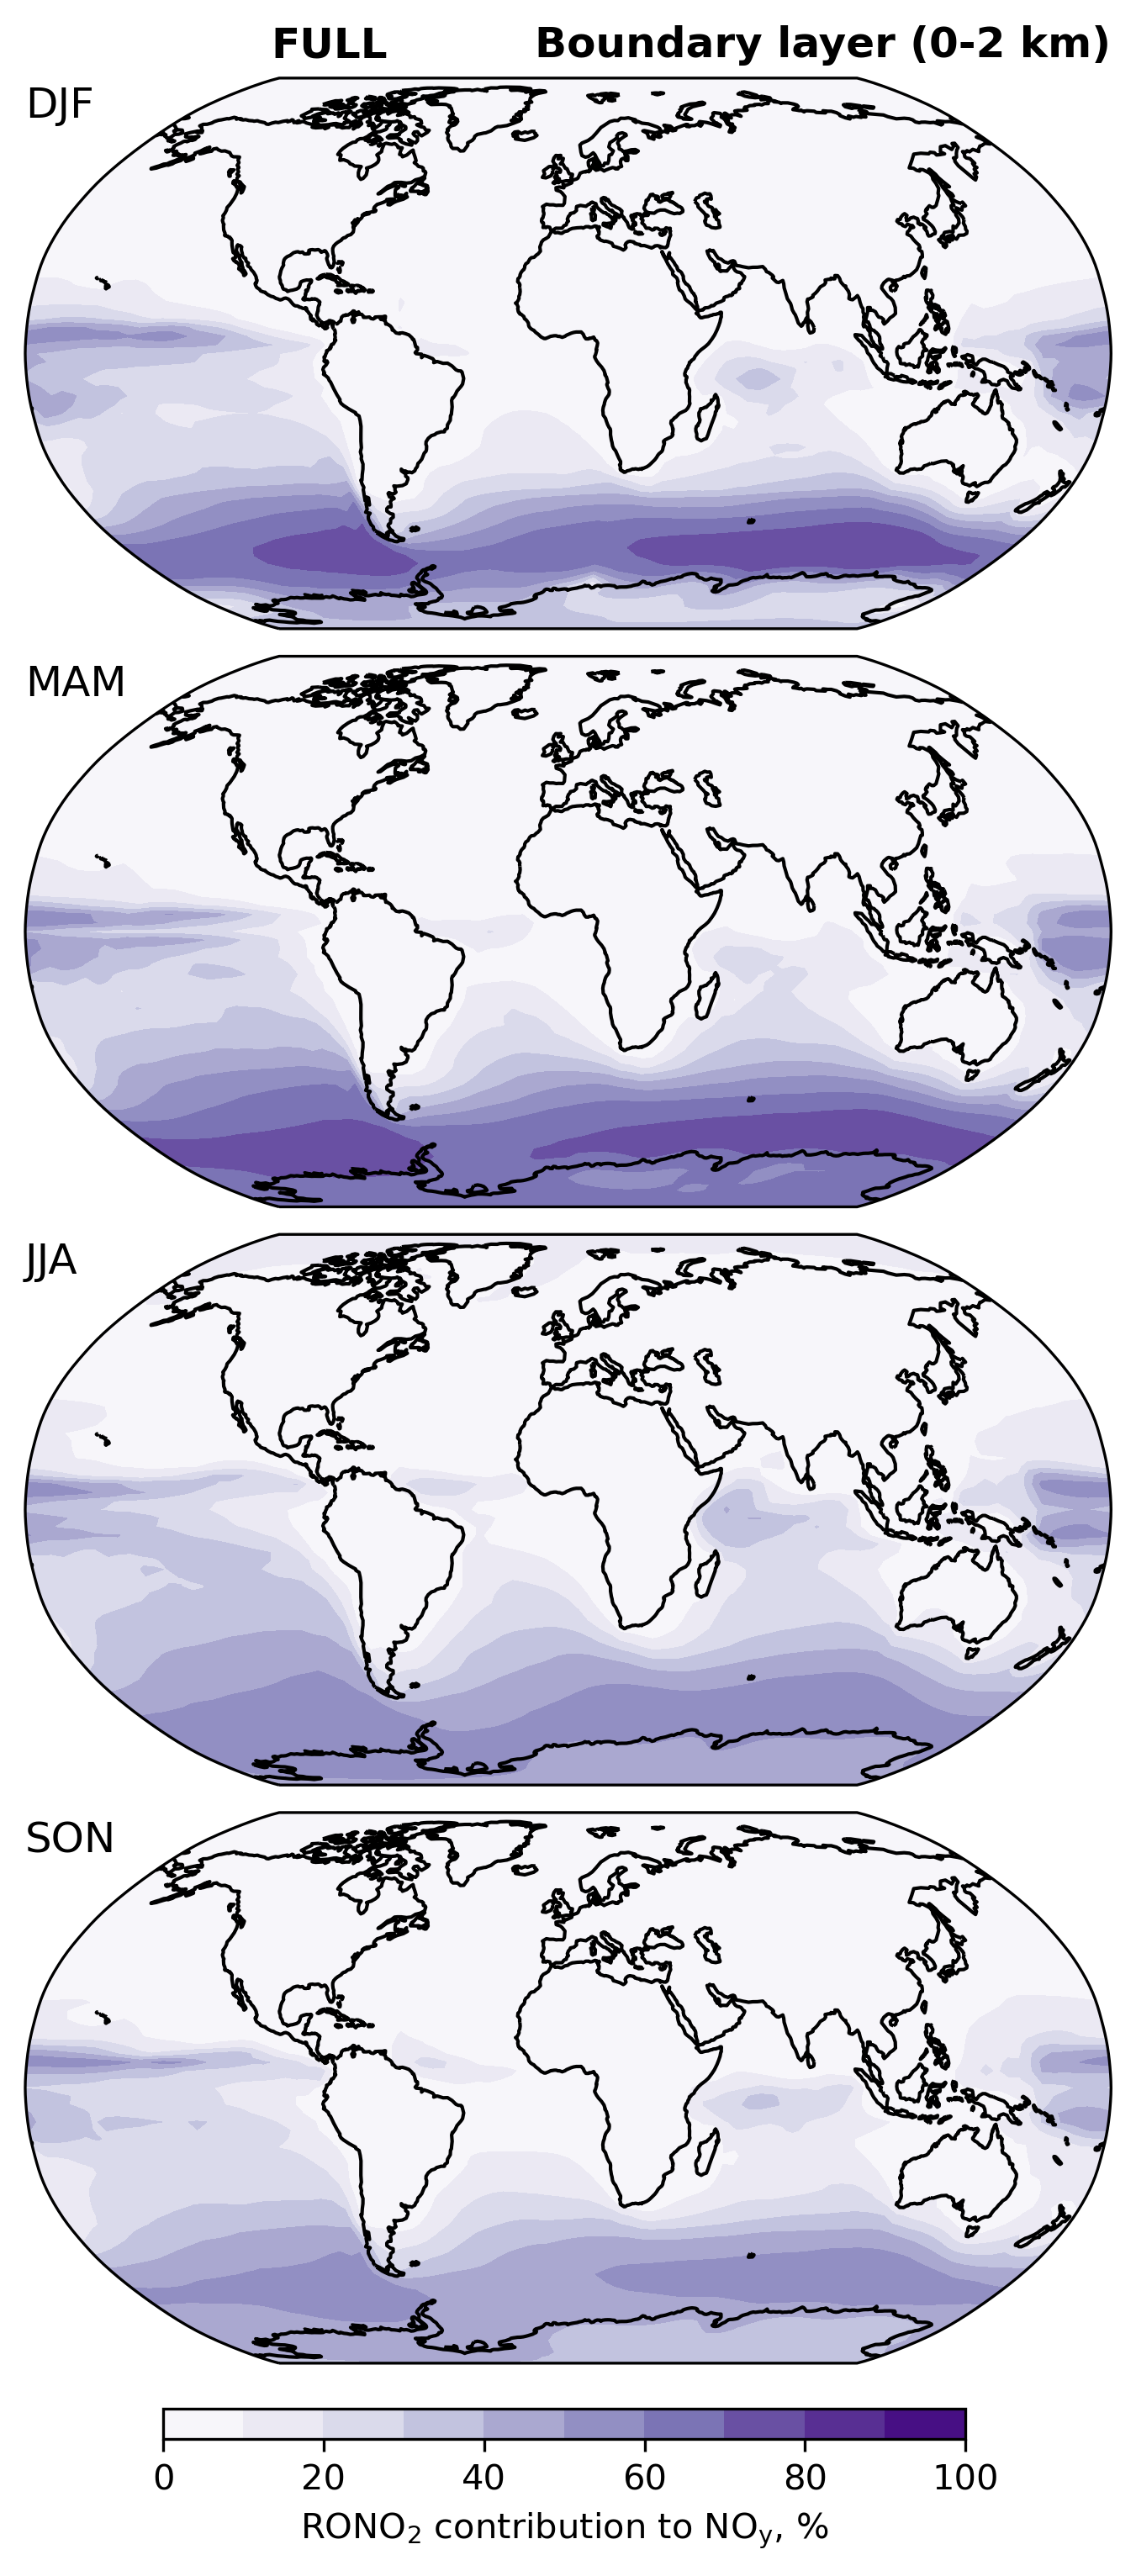

In [14]:
plt_ssn_means(sens_exp_name, sens_rono2_pct_of_noy, lons, lats)